# Predictions of likelihood of EPEs for Wellington region for 0 and 23 hours
This notebook is about the modelling of EPEs for Wellington region. ERA5 reanalysis data has been taken for 0 and 23 hours for 3 climate variables temp,
surface pressure and total column water

In [ ]:
# importing libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import xlrd
import seaborn as sns
import imblearn

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score, recall_score, accuracy_score, roc_auc_score

In [3]:
import sklearn
print('sklearn version {}'.format(sklearn.__version__))

sklearn version 0.24.0


# Reading data

In [2]:
# Function to read array dataset and convert it into dataframe

def get_data(file):
    # path of different variables data for Wellington region 
    file_path = '/mnt/temp/Projects/Emergence/Data_Keep/epe/ERA5_1d/' + file + '/average/Wellington_1d.nc'
    # Reading array dataset
    df = xr.open_dataset(file_path)
    # Converting array dataset into dataframe
    data = df.to_dataframe()
    
    return data
   

In [3]:
# To get temperature data and change it's column name to 'temp' 
data_t = get_data('2T')
df_t = data_t.rename(columns={'data':'temp'})
df_t

,temp
time,
1996-01-01 00:00:00,290.853851
1996-01-01 01:00:00,291.417694
1996-01-01 02:00:00,292.178162
1996-01-01 03:00:00,292.575165
1996-01-01 04:00:00,292.863342
...,...
2020-04-30 19:00:00,285.855133
2020-04-30 20:00:00,287.536957
2020-04-30 21:00:00,287.438690


In [4]:
# To get surface pressure data and change it's column name to 'sp' 
data_s = get_data('SP')
df_sp = data_s.rename(columns={'data':'sp'})

In [5]:
# To get total column water data and change it's column name to 'tcw'
data_w = get_data('TCW')
df_tcw = data_w.rename(columns={'data':'tcw'})

In [6]:
# combine 3 dataframes
frames = [df_t, df_sp, df_tcw]
new_data = pd.concat(frames, axis=1, sort=False)
new_data

,temp,sp,tcw
time,,,
1996-01-01 00:00:00,290.853851,100175.007812,16.728743
1996-01-01 01:00:00,291.417694,100133.265625,17.180902
1996-01-01 02:00:00,292.178162,100123.757812,17.231808
1996-01-01 03:00:00,292.575165,100070.734375,16.735910
1996-01-01 04:00:00,292.863342,100008.296875,16.049551
...,...,...,...
2020-04-30 19:00:00,285.855133,99768.148438,7.431450
2020-04-30 20:00:00,287.536957,99792.570312,7.424390
2020-04-30 21:00:00,287.438690,99826.421875,7.393387


# DataFrames

In [2]:
conda install xlrd

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


## Extreme dataframe

In [3]:
# Reading maximum events
sheat = pd.read_excel('/mnt/storage/Scratch/Fareeda/historical_ewes_tagged_202004241455.xlsx')
sheat


,Event date,HWE Event Title (black) / MetService Event Title (red),Source,Unnamed: 3,Regional Council region(s) affected,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34
0,NaT,NaN,NIWA,MetService,Nld,Ald,Wko,Bop,Gsb,Hby,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996-03-31,March 1996 Eastern North Island Ex-Tropical Cy...,1,NaN,NaN,NaN,NaN,NaN,3R,3R;3W,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1996-07-01,July 1996 South Island Snowfall,1,NaN,NaN,NaN,NaN,NaN,NaN,1S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1996-07-11,July 1996 Northland Auckland Rainfall,NaN,1,3R,3R,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1996-07-14,July 1996 Waikato Flooding,1,NaN,NaN,NaN,3R,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1299,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1300,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1301,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1302,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
# To check whether R exist in a column because we are interested in precipitation 
sheat['Unnamed: 12'].str.contains('R')

0      False
1        NaN
2        NaN
3        NaN
4        NaN
       ...  
833      NaN
834     True
835      NaN
836      NaN
837    False
Name: Unnamed: 12, Length: 838, dtype: object

In [8]:
# Extracting two columns (event date and wellington region) from sheat dataframe 
sh = sheat[['Event date', 'Unnamed: 12']]
sh

,Event date,Unnamed: 12
0,NaT,Wgn
1,1996-03-31,NaN
2,1996-07-01,NaN
3,1996-07-11,NaN
4,1996-07-14,NaN
...,...,...
833,2019-12-03,NaN
834,2019-12-08,2R
835,2019-12-16,NaN
836,2019-12-17,NaN


In [9]:
# Removing null rows
sh2 = sh.dropna()
sh2

,Event date,Unnamed: 12
8,1996-09-24,1T
9,1996-10-01,3W
10,1996-10-12,3R;3W
13,1996-11-18,3W
22,1997-03-11,\n
...,...,...
804,2018-12-02,3C
805,2018-12-03,2C
811,2019-03-08,3R
834,2019-12-08,2R


## Extreme event dataframe

In [10]:
# Define function 
def f(x):
    if 'R' in x:
        return 1
    else:
        return 0
    


In [11]:
# Creating new column and entering 1 if R is present otherwise 0
sh2['rain'] = sh2['Unnamed: 12'].apply(f)
sh2

<ipython-input-11-dc794b12be3d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sh2['rain'] = sh2['Unnamed: 12'].apply(f)


,Event date,Unnamed: 12,rain
8,1996-09-24,1T,0
9,1996-10-01,3W,0
10,1996-10-12,3R;3W,1
13,1996-11-18,3W,0
22,1997-03-11,\n,0
...,...,...,...
804,2018-12-02,3C,0
805,2018-12-03,2C,0
811,2019-03-08,3R,1
834,2019-12-08,2R,1


In [12]:
# selecting rows which contain 'R' in the Unnamed: 12 column
sh3 = sh2.loc[sh2['Unnamed: 12'].str.contains('R')]
sh3

,Event date,Unnamed: 12,rain
10,1996-10-12,3R;3W,1
28,1997-06-17,3R,1
30,1997-07-09,3R,1
36,1997-10-03,2R;3W,1
38,1997-11-14,3R,1
...,...,...,...
770,2018-02-01,3R;3W,1
788,2018-06-12,2R,1
791,2018-07-07,3R;3W,1
811,2019-03-08,3R,1


## Joining both dataframe

In [14]:
# To see new_data frame
new_data

,temp,sp,tcw
time,,,
1996-01-01 00:00:00,290.853851,100175.007812,16.728743
1996-01-01 01:00:00,291.417694,100133.265625,17.180902
1996-01-01 02:00:00,292.178162,100123.757812,17.231808
1996-01-01 03:00:00,292.575165,100070.734375,16.735910
1996-01-01 04:00:00,292.863342,100008.296875,16.049551
...,...,...,...
2020-04-30 19:00:00,285.855133,99768.148438,7.431450
2020-04-30 20:00:00,287.536957,99792.570312,7.424390
2020-04-30 21:00:00,287.438690,99826.421875,7.393387


In [13]:
# Subsetting for 0 or 23 hour from index
Hour_data = new_data.loc[(new_data.index.hour == 23) | (new_data.index.hour == 0)]
Hour_data

,temp,sp,tcw
time,,,
1996-01-01 00:00:00,290.853851,100175.007812,16.728743
1996-01-01 23:00:00,291.062653,100065.085938,16.694519
1996-01-02 00:00:00,291.241852,100039.437500,17.240368
1996-01-02 23:00:00,291.310394,99552.078125,12.764560
1996-01-03 00:00:00,291.230896,99499.601562,12.797529
...,...,...,...
2020-04-28 23:00:00,289.001801,100587.687500,9.099380
2020-04-29 00:00:00,289.154694,100527.953125,10.025865
2020-04-29 23:00:00,288.899017,100384.835938,8.654546


In [14]:
# Extracting rows for only 0 hour
H1 = Hour_data.loc[Hour_data.index.hour == 0]
H1

,temp,sp,tcw
time,,,
1996-01-01,290.853851,100175.007812,16.728743
1996-01-02,291.241852,100039.437500,17.240368
1996-01-03,291.230896,99499.601562,12.797529
1996-01-04,292.104889,99463.914062,19.124949
1996-01-05,291.501343,99918.070312,25.928146
...,...,...,...
2020-04-26,289.416504,99358.414062,14.770068
2020-04-27,289.074646,98926.929688,15.679741
2020-04-28,289.660126,99807.992188,10.210015


In [15]:
# extrecting rows of 23 hour
H2 = Hour_data.loc[Hour_data.index.hour == 23]
H2

,temp,sp,tcw
time,,,
1996-01-01 23:00:00,291.062653,100065.085938,16.694519
1996-01-02 23:00:00,291.310394,99552.078125,12.764560
1996-01-03 23:00:00,291.758911,99446.812500,18.472071
1996-01-04 23:00:00,291.247406,99894.804688,25.320429
1996-01-05 23:00:00,291.270721,100171.132812,27.919706
...,...,...,...
2020-04-26 23:00:00,289.346375,99010.437500,14.631294
2020-04-27 23:00:00,289.555847,99756.703125,10.016919
2020-04-28 23:00:00,289.001801,100587.687500,9.099380


In [16]:
# Changing index of H2 with the index of H1 because we want only dates in the index
H3 = H2.set_index(H1.index)
H3

,temp,sp,tcw
time,,,
1996-01-01,291.062653,100065.085938,16.694519
1996-01-02,291.310394,99552.078125,12.764560
1996-01-03,291.758911,99446.812500,18.472071
1996-01-04,291.247406,99894.804688,25.320429
1996-01-05,291.270721,100171.132812,27.919706
...,...,...,...
2020-04-26,289.346375,99010.437500,14.631294
2020-04-27,289.555847,99756.703125,10.016919
2020-04-28,289.001801,100587.687500,9.099380


In [17]:
# Creating new dataframe that will hold temp, sp, tcw columns seperately for 0 and 23 hour

Main_data = pd.DataFrame()
Main_data['temp1'] = H1['temp']
Main_data['temp2'] = H3['temp']
Main_data['SP1'] = H1['sp']
Main_data['SP2'] = H3['sp']
Main_data['tcw1'] = H1['tcw']
Main_data['tcw2'] = H3['tcw']
Main_data

,temp1,temp2,SP1,SP2,tcw1,tcw2
time,,,,,,
1996-01-01,290.853851,291.062653,100175.007812,100065.085938,16.728743,16.694519
1996-01-02,291.241852,291.310394,100039.437500,99552.078125,17.240368,12.764560
1996-01-03,291.230896,291.758911,99499.601562,99446.812500,12.797529,18.472071
1996-01-04,292.104889,291.247406,99463.914062,99894.804688,19.124949,25.320429
1996-01-05,291.501343,291.270721,99918.070312,100171.132812,25.928146,27.919706
...,...,...,...,...,...,...
2020-04-26,289.416504,289.346375,99358.414062,99010.437500,14.770068,14.631294
2020-04-27,289.074646,289.555847,98926.929688,99756.703125,15.679741,10.016919
2020-04-28,289.660126,289.001801,99807.992188,100587.687500,10.210015,9.099380


In [18]:
# changing the index of sh4 with sh2 because we want to join this dataframe with main_data dataframe
sh4 = sh2.set_index('Event date')
sh4

,Unnamed: 12,rain
Event date,,
1996-09-24,1T,0
1996-10-01,3W,0
1996-10-12,3R;3W,1
1996-11-18,3W,0
1997-03-11,\n,0
...,...,...
2018-12-02,3C,0
2018-12-03,2C,0
2019-03-08,3R,1


In [19]:
# Joining main_data and sh4 dataframes
Fin_data = Main_data.join(sh4)
Fin_data

,temp1,temp2,SP1,SP2,tcw1,tcw2,Unnamed: 12,rain
time,,,,,,,,
1996-01-01,290.853851,291.062653,100175.007812,100065.085938,16.728743,16.694519,NaN,NaN
1996-01-02,291.241852,291.310394,100039.437500,99552.078125,17.240368,12.764560,NaN,NaN
1996-01-03,291.230896,291.758911,99499.601562,99446.812500,12.797529,18.472071,NaN,NaN
1996-01-04,292.104889,291.247406,99463.914062,99894.804688,19.124949,25.320429,NaN,NaN
1996-01-05,291.501343,291.270721,99918.070312,100171.132812,25.928146,27.919706,NaN,NaN
...,...,...,...,...,...,...,...,...
2020-04-26,289.416504,289.346375,99358.414062,99010.437500,14.770068,14.631294,NaN,NaN
2020-04-27,289.074646,289.555847,98926.929688,99756.703125,15.679741,10.016919,NaN,NaN
2020-04-28,289.660126,289.001801,99807.992188,100587.687500,10.210015,9.099380,NaN,NaN


In [20]:
# Replacing nan with 0 in the rain column
Fin_data['rain'] = Fin_data['rain'].fillna(0)
Fin_data = Fin_data.drop('Unnamed: 12', axis=1)

### Final dataframe

In [21]:
Fin_data

,temp1,temp2,SP1,SP2,tcw1,tcw2,rain
time,,,,,,,
1996-01-01,290.853851,291.062653,100175.007812,100065.085938,16.728743,16.694519,0.0
1996-01-02,291.241852,291.310394,100039.437500,99552.078125,17.240368,12.764560,0.0
1996-01-03,291.230896,291.758911,99499.601562,99446.812500,12.797529,18.472071,0.0
1996-01-04,292.104889,291.247406,99463.914062,99894.804688,19.124949,25.320429,0.0
1996-01-05,291.501343,291.270721,99918.070312,100171.132812,25.928146,27.919706,0.0
...,...,...,...,...,...,...,...
2020-04-26,289.416504,289.346375,99358.414062,99010.437500,14.770068,14.631294,0.0
2020-04-27,289.074646,289.555847,98926.929688,99756.703125,15.679741,10.016919,0.0
2020-04-28,289.660126,289.001801,99807.992188,100587.687500,10.210015,9.099380,0.0


In [62]:
Fin_data.to_csv('dataframe.csv', sep='\t')

In [36]:
# To see total counts for 1 and 0
Fin_data.rain.value_counts()

0.0    8811
1.0      76
Name: rain, dtype: int64

In [178]:
Fin_data.rain['2019-12-08']

1.0

In [179]:
Fin_data.rain['2019-12-20']

0.0

# Modelling

In [22]:
# Split data into X and Y
X = Fin_data.drop('rain', axis=1)
Y = Fin_data['rain']
X

,temp1,temp2,SP1,SP2,tcw1,tcw2
time,,,,,,
1996-01-01,290.853851,291.062653,100175.007812,100065.085938,16.728743,16.694519
1996-01-02,291.241852,291.310394,100039.437500,99552.078125,17.240368,12.764560
1996-01-03,291.230896,291.758911,99499.601562,99446.812500,12.797529,18.472071
1996-01-04,292.104889,291.247406,99463.914062,99894.804688,19.124949,25.320429
1996-01-05,291.501343,291.270721,99918.070312,100171.132812,25.928146,27.919706
...,...,...,...,...,...,...
2020-04-26,289.416504,289.346375,99358.414062,99010.437500,14.770068,14.631294
2020-04-27,289.074646,289.555847,98926.929688,99756.703125,15.679741,10.016919
2020-04-28,289.660126,289.001801,99807.992188,100587.687500,10.210015,9.099380


In [38]:
Y

time
1996-01-01    0.0
1996-01-02    0.0
1996-01-03    0.0
1996-01-04    0.0
1996-01-05    0.0
             ... 
2020-04-26    0.0
2020-04-27    0.0
2020-04-28    0.0
2020-04-29    0.0
2020-04-30    0.0
Name: rain, Length: 8887, dtype: float64

In [39]:
# Split data into train and test 
np.random.seed(42)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Logistic regression

In [40]:
# Fit the model to the data

model = LogisticRegression()
model = model.fit(X_train, Y_train)

In [41]:
# Evaluate the model 
model.score(X_test, Y_test)

0.9881889763779528

In [42]:
# Y prediction whether 0 or 1
Y_predict = model.predict(X_test)
Y_predict

array([0., 0., 0., ..., 0., 0., 0.])

In [34]:
Y_predict.max()

0.0

In [43]:
# probability of prediction of 0 & 1
model.predict_proba(X_test)

array([[0.99853757, 0.00146243],
       [0.99429271, 0.00570729],
       [0.99485888, 0.00514112],
       ...,
       [0.9975769 , 0.0024231 ],
       [0.99686768, 0.00313232],
       [0.99299962, 0.00700038]])

In [44]:
confusion_matrix(Y_test, Y_predict)

array([[1757,    0],
       [  21,    0]])

In [45]:
print(confusion_matrix(Y_test, Y_predict))

[[1757    0]
 [  21    0]]


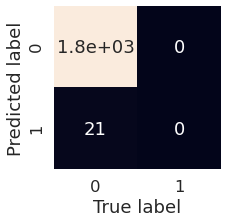

In [46]:
sns.set(font_scale=1.5)

def plot_confusion_mat(Y_test, Y_predict):
    """
    Plot a nice looking confusion matrix using seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(Y_test, Y_predict), 
                    annot = True,
                    cbar=False)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_confusion_mat(Y_test, Y_predict)    

In [43]:
print(classification_report(Y_test, Y_predict))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1757
         1.0       0.00      0.00      0.00        21

    accuracy                           0.99      1778
   macro avg       0.49      0.50      0.50      1778
weighted avg       0.98      0.99      0.98      1778



/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
f1_score(Y_test, Y_predict)

0.0

In [58]:
recall_score(Y_test, Y_predict)

0.0

In [52]:
predictions = pd.DataFrame(Y_predict)
predictions

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
1773,0.0
1774,0.0
1775,0.0
1776,0.0


In [53]:
predictions[0].value_counts()

0.0    1778
Name: 0, dtype: int64

## RandomForest

In [47]:
model1 = RandomForestClassifier(n_estimators=10)

model1 = model1.fit(X_train, Y_train)

In [48]:
model1.score(X_test, Y_test)

0.9876265466816648

In [49]:
cross_val_score(model1, X_test, Y_test, cv=5)

array([0.98876404, 0.98876404, 0.98595506, 0.98873239, 0.98873239])

In [50]:
model1_predict = model1.predict(X_test)

In [51]:
confusion_matrix(Y_test, model1_predict)

array([[1756,    1],
       [  21,    0]])

In [66]:
print(classification_report(Y_test, model1_predict))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1757
         1.0       0.00      0.00      0.00        21

    accuracy                           0.99      1778
   macro avg       0.49      0.50      0.50      1778
weighted avg       0.98      0.99      0.98      1778



/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# Resampling

## Oversampling


In [106]:
from sklearn.utils import resample

# Concatenate training data back togather
X = pd.concat([X_train, Y_train], axis=1)
X.head()

,temp1,temp2,SP1,SP2,tcw1,tcw2,rain
time,,,,,,,
1998-03-26,291.768890,290.518524,99726.117188,99947.898438,19.707582,18.463655,0.0
2009-04-04,288.917633,290.227997,100375.289062,99916.640625,8.103856,9.358947,0.0
1997-09-10,286.398865,284.237854,99057.984375,97909.007812,13.228416,18.827896,0.0
2006-02-05,290.729431,288.834778,98276.328125,99007.710938,18.589233,15.887465,0.0
2016-12-31,290.557343,292.072754,98641.742188,97940.453125,15.025950,32.772285,0.0


In [34]:
# Seperating minority & majority classes
not_rain = X[X.rain==0]
rain = X[X.rain==1]

In [79]:
not_rain.head()

,temp1,temp2,SP1,SP2,tcw1,tcw2,rain
time,,,,,,,
1998-03-26,291.768890,290.518524,99726.117188,99947.898438,19.707582,18.463655,0.0
2009-04-04,288.917633,290.227997,100375.289062,99916.640625,8.103856,9.358947,0.0
1997-09-10,286.398865,284.237854,99057.984375,97909.007812,13.228416,18.827896,0.0
2006-02-05,290.729431,288.834778,98276.328125,99007.710938,18.589233,15.887465,0.0
2016-12-31,290.557343,292.072754,98641.742188,97940.453125,15.025950,32.772285,0.0


In [78]:
rain.head()

,temp1,temp2,SP1,SP2,tcw1,tcw2,rain
time,,,,,,,
2001-11-22,288.810364,285.454407,97827.109375,97675.085938,38.995815,25.160254,1.0
2003-06-08,287.634644,286.134338,98647.671875,97894.851562,7.288258,25.581177,1.0
2005-03-29,290.017853,288.071808,98429.742188,98812.632812,21.281834,28.096525,1.0
1998-10-27,290.820312,290.844086,98535.523438,98165.625000,30.722002,34.293579,1.0
2008-06-22,285.469147,284.002625,97380.312500,96385.125000,26.026836,20.335007,1.0


In [35]:
# upsample minority class
rain_upsample = resample(rain,
                         replace=True, # sample with replacement
                         n_samples=len(not_rain), # match number in majority class
                         random_state=27)

In [80]:
rain_upsample.head()

,temp1,temp2,SP1,SP2,tcw1,tcw2,rain
time,,,,,,,
2008-10-07,287.938110,286.087189,96373.742188,97089.546875,27.599371,10.106321,1.0
2019-03-08,290.591278,290.575134,99141.046875,99303.921875,34.074757,17.674967,1.0
2010-01-14,292.317688,288.658905,98383.195312,98778.109375,14.802686,28.993168,1.0
2002-10-25,290.048279,286.301117,97455.125000,97364.375000,27.648497,15.375426,1.0
2005-01-05,288.184296,291.570923,97867.523438,97647.875000,32.728134,25.577227,1.0


In [81]:
# Combine majority and upsampling minority
upsample = pd.concat([not_rain, rain_upsample])
upsample.head()

,temp1,temp2,SP1,SP2,tcw1,tcw2,rain
time,,,,,,,
1998-03-26,291.768890,290.518524,99726.117188,99947.898438,19.707582,18.463655,0.0
2009-04-04,288.917633,290.227997,100375.289062,99916.640625,8.103856,9.358947,0.0
1997-09-10,286.398865,284.237854,99057.984375,97909.007812,13.228416,18.827896,0.0
2006-02-05,290.729431,288.834778,98276.328125,99007.710938,18.589233,15.887465,0.0
2016-12-31,290.557343,292.072754,98641.742188,97940.453125,15.025950,32.772285,0.0


In [37]:
upsample.rain.value_counts()

1.0    7054
0.0    7054
Name: rain, dtype: int64

## Logistic regression with balanced data

In [38]:
y_train = upsample.rain
x_train = upsample.drop('rain', axis=1)

In [40]:
# Model fitting
upsampled_model = LogisticRegression(solver='liblinear').fit(x_train, y_train)

In [43]:
upsampled_pred = upsampled_model.predict(X_test)
upsampled_pred

array([0., 1., 0., ..., 0., 0., 0.])

In [45]:
print(classification_report(Y_test, upsampled_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86      1757
         1.0       0.03      0.52      0.05        21

    accuracy                           0.76      1778
   macro avg       0.51      0.64      0.45      1778
weighted avg       0.98      0.76      0.85      1778



In [49]:
accuracy_score(Y_test, upsampled_pred)

0.7570303712035995

In [50]:
print(confusion_matrix(Y_test, upsampled_pred))

[[1335  422]
 [  10   11]]


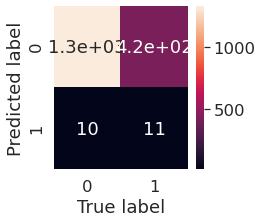

In [54]:
sns.set(font_scale=1.5)

def plot_confusion_mat(Y_test, Y_predict):
    """
    Plot a nice looking confusion matrix using seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(Y_test, Y_predict), 
                    annot = True,
                    cbar=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_confusion_mat(Y_test, upsampled_pred)   

In [56]:
upsampled_data = pd.DataFrame(upsampled_pred)
upsampled_data[0].value_counts()

0.0    1345
1.0     433
Name: 0, dtype: int64

In [109]:
print(roc_auc_score(Y_test, upsampled_pred))

0.6418136975905899


## RandomForest

In [117]:
upsampled_model1 = RandomForestClassifier(class_weight={0:1, 1:10}).fit(x_train, y_train)

In [118]:
upsampled_model1_pred = upsampled_model1.predict(X_test)

In [119]:
accuracy_score(Y_test, upsampled_model1_pred)

0.9881889763779528

In [120]:
print(classification_report(Y_test, upsampled_model1_pred ))

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1757
         1.0       0.00      0.00      0.00        21

    accuracy                           0.99      1778
   macro avg       0.49      0.50      0.50      1778
weighted avg       0.98      0.99      0.98      1778



/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [92]:
pd.DataFrame(confusion_matrix(Y_test, upsampled_model1_pred))

,0,1
0,1757,0
1,21,0


## Decision Tree

In [132]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

clf = clf.fit(x_train, y_train)

clf_pred = clf.predict(X_test)

accuracy_score(Y_test, clf_pred)

0.9814398200224972

In [133]:
print(confusion_matrix(Y_test, clf_pred))

[[1743   14]
 [  19    2]]


# Penalize Algorithm

In [84]:
from sklearn.svm import SVC

# we can add class_weight='balanced' to add penalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

In [151]:
svc_model = svc_model.fit(X_train, Y_train)

In [152]:
svc_pred = svc_model.predict(X_test)

In [154]:
print(confusion_matrix(Y_test, svc_pred))

[[1187  570]
 [   4   17]]


In [155]:
print(classification_report(Y_test, svc_pred))

              precision    recall  f1-score   support

         0.0       1.00      0.68      0.81      1757
         1.0       0.03      0.81      0.06        21

    accuracy                           0.68      1778
   macro avg       0.51      0.74      0.43      1778
weighted avg       0.99      0.68      0.80      1778



### penalize oversampling

In [156]:
svc_model1 = svc_model.fit(x_train, y_train)

In [158]:
svc_pred1 = svc_model1.predict(X_test)

In [159]:
print(confusion_matrix(Y_test, svc_pred1))

[[1241  516]
 [   6   15]]


# Undersampling

In [59]:
# Downsampling majority class
not_rain_downsampling = resample(not_rain,
                                 replace  = False, #sample without replacement
                                 n_samples = len(rain), # match minority n
                                 random_state=27)

In [71]:
#not_rain_downsampling

In [61]:
downsampled = pd.concat([not_rain_downsampling, rain])

In [62]:
downsampled.rain.value_counts()

1.0    55
0.0    55
Name: rain, dtype: int64

In [65]:
y1_train = downsampled.rain
x1_train = downsampled.drop('rain', axis=1)

In [66]:
undersampled_model = LogisticRegression(solver='liblinear').fit(x1_train, y1_train)

In [68]:
undersampled_pred = undersampled_model.predict(X_test)

In [69]:
accuracy_score(Y_test, undersampled_pred)

0.7559055118110236

In [70]:
print(classification_report(Y_test, undersampled_pred))

              precision    recall  f1-score   support

         0.0       0.99      0.76      0.86      1757
         1.0       0.03      0.57      0.05        21

    accuracy                           0.76      1778
   macro avg       0.51      0.66      0.46      1778
weighted avg       0.98      0.76      0.85      1778



In [72]:
print(confusion_matrix(Y_test, undersampled_pred))

[[1332  425]
 [   9   12]]


In [77]:
pd.DataFrame(confusion_matrix(Y_test, undersampled_pred))

,0,1
0,1332,425
1,9,12


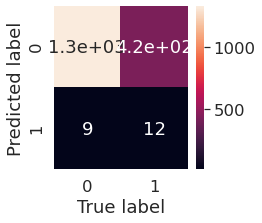

In [73]:
sns.set(font_scale=1.5)

def plot_confusion_mat(Y_test, Y_predict):
    """
    Plot a nice looking confusion matrix using seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(Y_test, Y_predict), 
                    annot = True,
                    cbar=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_confusion_mat(Y_test, undersampled_pred)  

## RandomForest

In [161]:
undersampled_model1 = RandomForestClassifier().fit(x1_train, y1_train)

#  RandomForest with diff oversampling method

In [49]:
# Function to test diff oversampling methods with Randomforest 
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import BorderlineSMOTE
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV


np.random.seed(42)

upsample = {'RandomOverSampler': RandomOverSampler , 
            'SMOTETomek': SMOTETomek, 
            'SMOTEENN' :SMOTEENN, 
            'SMOTE' : SMOTE, 
            'ADASYN': ADASYN,
             'BorderlineSMOTE':BorderlineSMOTE }

grid = {'n_estimators' : [10, 100, 200, 500, 1000, 1200],
       'max_depth' : [None, 5, 10, 20, 30],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6],
       'min_samples_leaf' : [1, 2, 4]}


def over_sample(x_train, y_train, x_test, y_test):
    # Looping methods
    for name, method in upsample.items():
        
        upsam = method()
        
        x_upsam, y_upsam = upsam.fit_resample(x_train, y_train)
        
        model = RandomForestClassifier().fit(x_upsam, y_upsam)
        
        # Setup RandomilzedSearchCV
#         rs_clf1 = RandomizedSearchCV(estimator = clf,
#                            param_distributions=grid,
#                            n_iter=20, # try 20 models total
#                            cv=5 # 5-fold cross-validation
#                              ).fit(x_upsam, y_upsam)

        
        y_pred = model.predict(x_test)
        
        
        print('confusion matrix for ' + str(name))
        print(metrics.confusion_matrix(y_test, y_pred))
#         print(metrics.classification_report(y_test, y_pred_ros))
#         print('Accuracy {}'.format(metrics.accuracy_score(y_test, y_pred_ros)) )
#         print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, y_pred_ros)))
        
        
over_sample(x_train, y_train, x_test, y_test)  

confusion matrix for RandomOverSampler
[[1757    0]
 [  21    0]]
confusion matrix for SMOTETomek
[[1722   35]
 [  17    4]]
confusion matrix for SMOTEENN
[[1699   58]
 [  16    5]]
confusion matrix for SMOTE
[[1723   34]
 [  16    5]]
confusion matrix for ADASYN
[[1712   45]
 [  16    5]]
confusion matrix for BorderlineSMOTE
[[1751    6]
 [  20    1]]


# RandomOverSampler
RandomOverSampler individually with RandomForest


In [57]:
from imblearn.over_sampling import RandomOverSampler


ros = RandomOverSampler(random_state=42)

x_ros, y_ros = ros.fit_resample(x_train, y_train)

In [58]:
y_ros.value_counts()

0.0    7054
1.0    7054
Name: rain, dtype: int64

In [63]:
model_ros = RandomForestClassifier().fit(x_ros, y_ros)

y_pred_ros = model_ros.predict(x_test)

print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred_ros))
print(metrics.classification_report(y_test, y_pred_ros))
print('Accuracy {}'.format(metrics.accuracy_score(y_test, y_pred_ros)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, y_pred_ros)))

confusion matrix
[[1757    0]
 [  21    0]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1757
         1.0       0.00      0.00      0.00        21

    accuracy                           0.99      1778
   macro avg       0.49      0.50      0.50      1778
weighted avg       0.98      0.99      0.98      1778

Accuracy 0.9881889763779528
Area under the curve 0.5


# SMOTETomek
SMOTETomek individually with RandomForest


In [70]:
from imblearn.combine import SMOTETomek

rs = SMOTETomek(random_state=42)

x_rs, y_rs = rs.fit_resample(x_train, y_train)

model_rs = RandomForestClassifier().fit(x_rs, y_rs)

y_pred_rs = model_rs.predict(x_test)

print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred_rs))
print(metrics.classification_report(y_test, y_pred_rs))
print('Accuracy {}'.format(metrics.accuracy_score(y_test, y_pred_rs)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, y_pred_rs)))

confusion matrix
[[1717   40]
 [  17    4]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98      1757
         1.0       0.09      0.19      0.12        21

    accuracy                           0.97      1778
   macro avg       0.54      0.58      0.55      1778
weighted avg       0.98      0.97      0.97      1778

Accuracy 0.967941507311586
Area under the curve 0.5838550559666097


## SMOTETomek with MultinomialNB 

In [71]:
from sklearn.naive_bayes import MultinomialNB

model = MultinomialNB().fit(x_rs, y_rs)

y_pred = model.predict(x_test)

print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred))
print(metrics.classification_report(y_test, y_pred))
print('Accuracy {}'.format(metrics.accuracy_score(y_test, y_pred)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, y_pred)))



confusion matrix
[[1351  406]
 [   6   15]]
              precision    recall  f1-score   support

         0.0       1.00      0.77      0.87      1757
         1.0       0.04      0.71      0.07        21

    accuracy                           0.77      1778
   macro avg       0.52      0.74      0.47      1778
weighted avg       0.98      0.77      0.86      1778

Accuracy 0.7682789651293588
Area under the curve 0.7416050085372794


# XGBoost 

In [26]:
X

,temp1,temp2,SP1,SP2,tcw1,tcw2
time,,,,,,
1996-01-01,290.853851,291.062653,100175.007812,100065.085938,16.728743,16.694519
1996-01-02,291.241852,291.310394,100039.437500,99552.078125,17.240368,12.764560
1996-01-03,291.230896,291.758911,99499.601562,99446.812500,12.797529,18.472071
1996-01-04,292.104889,291.247406,99463.914062,99894.804688,19.124949,25.320429
1996-01-05,291.501343,291.270721,99918.070312,100171.132812,25.928146,27.919706
...,...,...,...,...,...,...
2020-04-26,289.416504,289.346375,99358.414062,99010.437500,14.770068,14.631294
2020-04-27,289.074646,289.555847,98926.929688,99756.703125,15.679741,10.016919
2020-04-28,289.660126,289.001801,99807.992188,100587.687500,10.210015,9.099380


In [27]:
Y

time
1996-01-01    0.0
1996-01-02    0.0
1996-01-03    0.0
1996-01-04    0.0
1996-01-05    0.0
             ... 
2020-04-26    0.0
2020-04-27    0.0
2020-04-28    0.0
2020-04-29    0.0
2020-04-30    0.0
Name: rain, Length: 8887, dtype: float64

## Imbalanced data

In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

from xgboost.sklearn import XGBClassifier

xgb_model = XGBClassifier()

print(xgb_model.get_xgb_params())



{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': None, 'gpu_id': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [44]:
xgb_model.fit(x_train, y_train, eval_metric=['error'], eval_set=[(x_train, y_train), (x_test, y_test)])

[14:42:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[0]	validation_0-logloss:0.44536	validation_1-logloss:0.44796
[1]	validation_0-logloss:0.30864	validation_1-logloss:0.31318
[2]	validation_0-logloss:0.22274	validation_1-logloss:0.22920
[3]	validation_0-logloss:0.16506	validation_1-logloss:0.17409
[4]	validation_0-logloss:0.12518	validation_1-logloss:0.13693
[5]	validation_0-logloss:0.09688	validation_1-logloss:0.11128
[6]	validation_0-logloss:0.07671	validation_1-logloss:0.09357
[7]	validation_0-logloss:0.06139	validation_1-logloss:0.08116
[8]	validation_0-logloss:0.05007	validation_1-logloss:0.07262
[9]	validation_0-logloss:0.04147	validation_1-logloss:0.06675
[10]	validation_0-logloss:0.03530	validation_1-logloss:0.0629

/home/fareeda/miniconda3/envs/bs38/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[19]	validation_0-logloss:0.01394	validation_1-logloss:0.05913
[20]	validation_0-logloss:0.01324	validation_1-logloss:0.05946
[21]	validation_0-logloss:0.01232	validation_1-logloss:0.05986
[22]	validation_0-logloss:0.01174	validation_1-logloss:0.06012
[23]	validation_0-logloss:0.01127	validation_1-logloss:0.06055
[24]	validation_0-logloss:0.01090	validation_1-logloss:0.06115
[25]	validation_0-logloss:0.01032	validation_1-logloss:0.06141
[26]	validation_0-logloss:0.00973	validation_1-logloss:0.06239
[27]	validation_0-logloss:0.00945	validation_1-logloss:0.06274
[28]	validation_0-logloss:0.00921	validation_1-logloss:0.06326
[29]	validation_0-logloss:0.00906	validation_1-logloss:0.06358
[30]	validation_0-logloss:0.00883	validation_1-logloss:0.06429
[31]	validation_0-logloss:0.00864	validation_1-logloss:0.06448
[32]	validation_0-logloss:0.00815	validation_1-logloss:0.06563
[33]	validation_0-logloss:0.00785	validation_1-logloss:0.06610
[34]	validation_0-logloss:0.00772	validation_1-logloss:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [45]:
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

y_pred = xgb_model.predict(x_test) 
print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred))
print('classification report')
print(metrics.classification_report(y_test, y_pred))
print('Accuracy')
print(metrics.accuracy_score(y_test, y_pred))
print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, y_pred)))


confusion matrix
[[1757    0]
 [  21    0]]
classification report
              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1757
         1.0       0.00      0.00      0.00        21

    accuracy                           0.99      1778
   macro avg       0.49      0.50      0.50      1778
weighted avg       0.98      0.99      0.98      1778

Accuracy
0.9881889763779528
Area under the curve 0.5


# SMOTE
Balanced train data and imbalanced test data


In [48]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [26]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((7109, 6), (1778, 6), (7109,), (1778,))

In [27]:
print(y_train.value_counts())
print(y_test.value_counts())

0.0    7054
1.0      55
Name: rain, dtype: int64
0.0    1757
1.0      21
Name: rain, dtype: int64


In [36]:
# upsampling train data
from collections import Counter
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
x_upsam, y_upsam = sm.fit_sample(x_train, y_train)


In [27]:
y_upsam.value_counts()

0.0    7054
1.0    7054
Name: rain, dtype: int64

## XGBoost

In [32]:
from xgboost.sklearn import XGBClassifier
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')


xgb_model = XGBClassifier()

print(xgb_model.get_xgb_params())

{'objective': 'binary:logistic', 'base_score': None, 'booster': None, 'colsample_bylevel': None, 'colsample_bynode': None, 'colsample_bytree': None, 'gamma': None, 'gpu_id': None, 'interaction_constraints': None, 'learning_rate': None, 'max_delta_step': None, 'max_depth': None, 'min_child_weight': None, 'monotone_constraints': None, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'scale_pos_weight': None, 'subsample': None, 'tree_method': None, 'validate_parameters': None, 'verbosity': None}


In [33]:
xgb_model.fit(x_upsam, y_upsam)

[09:18:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [34]:
y_pred_upsam = xgb_model.predict(x_test)

print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred_upsam))
print(metrics.classification_report(y_test, y_pred_upsam))
print('Accuracy {}'.format(metrics.accuracy_score(y_test, y_pred_upsam)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, y_pred_upsam)))

confusion matrix
[[1711   46]
 [  16    5]]
              precision    recall  f1-score   support

         0.0       0.99      0.97      0.98      1757
         1.0       0.10      0.24      0.14        21

    accuracy                           0.97      1778
   macro avg       0.54      0.61      0.56      1778
weighted avg       0.98      0.97      0.97      1778

Accuracy 0.9651293588301463
Area under the curve 0.6059571238854108


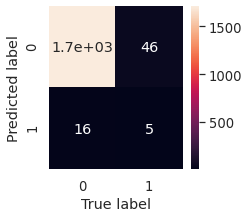

In [35]:
sns.set(font_scale=1.2)

def plot_confusion_mat(Y_test, Y_predict):
    """
    Plot a nice looking confusion matrix using seaborn's heatmap()
    """
    fig, ax = plt.subplots(figsize=(3,3))
    ax = sns.heatmap(confusion_matrix(Y_test, Y_predict), 
                    annot = True,
                    cbar=True)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    
    bottom, top = ax.get_ylim()
    #ax.set_ylim(bottom + 0.5, top - 0.5)
    
plot_confusion_mat(y_test, y_pred_upsam) 

## LogisticRegression

In [38]:
# LogisticRegression
model1 = LogisticRegression(solver='liblinear').fit(x_upsam, y_upsam)

y_pred1  = model1.predict(x_test)

print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred1))
print(metrics.classification_report(y_test, y_pred1))
print('Accuracy {}'.format(metrics.accuracy_score(y_test, y_pred1)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, y_pred1)))


confusion matrix
[[1352  405]
 [  10   11]]
              precision    recall  f1-score   support

         0.0       0.99      0.77      0.87      1757
         1.0       0.03      0.52      0.05        21

    accuracy                           0.77      1778
   macro avg       0.51      0.65      0.46      1778
weighted avg       0.98      0.77      0.86      1778

Accuracy 0.7665916760404949
Area under the curve 0.6466514892809714


## SVC

In [40]:
# svc model
from sklearn.svm import SVC


svc_model = SVC()

In [41]:
model5 = svc_model.fit(x_upsam, y_upsam)

y_pred5 = model5.predict(x_test)

print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred5))
print(metrics.classification_report(y_test, y_pred5))
print('Accuracy {}'.format(metrics.accuracy_score(y_test, y_pred5)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, y_pred5)))

confusion matrix
[[1232  525]
 [   4   17]]
              precision    recall  f1-score   support

         0.0       1.00      0.70      0.82      1757
         1.0       0.03      0.81      0.06        21

    accuracy                           0.70      1778
   macro avg       0.51      0.76      0.44      1778
weighted avg       0.99      0.70      0.81      1778

Accuracy 0.7024746906636671
Area under the curve 0.7553595143236578


## Decision Tree

In [33]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

np.random.seed(42)

dt = DecisionTreeClassifier()

model6 = dt.fit(x_upsam, y_upsam)

y_pred6 = model6.predict(x_test)

print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred6))
print(metrics.classification_report(y_test, y_pred6))
print('Accuracy {}'.format(metrics.accuracy_score(y_test, y_pred6)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, y_pred6)))

confusion matrix
[[1679   78]
 [  17    4]]
              precision    recall  f1-score   support

         0.0       0.99      0.96      0.97      1757
         1.0       0.05      0.19      0.08        21

    accuracy                           0.95      1778
   macro avg       0.52      0.57      0.53      1778
weighted avg       0.98      0.95      0.96      1778

Accuracy 0.9465691788526435
Area under the curve 0.5730411686586986


## RandomForest

In [35]:
# RandomForest
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

model2 = RandomForestClassifier().fit(x_upsam, y_upsam)

y_pred2 = model2.predict(x_test)

print('confusion matrix')
print(metrics.confusion_matrix(y_test, y_pred2))
print(metrics.classification_report(y_test, y_pred2))
print('Accuracy {}'.format(metrics.accuracy_score(y_test, y_pred2)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, y_pred2)))

confusion matrix
[[1721   36]
 [  16    5]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1757
         1.0       0.12      0.24      0.16        21

    accuracy                           0.97      1778
   macro avg       0.56      0.61      0.57      1778
weighted avg       0.98      0.97      0.98      1778

Accuracy 0.9707536557930259
Area under the curve 0.6088028837032821


In [32]:
model2.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

### Hyperparameter tunning (RandomForest)

#### Randomizedsearchcv

In [43]:
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(42)

# Hyperparameter grid RandomizedSearchCV will search over
grid = {'n_estimators' : [10, 100, 200, 500, 1000, 1200],
       'max_depth' : [None, 5, 10, 20, 30],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6],
       'min_samples_leaf' : [1, 2, 4]}

clf = RandomForestClassifier(n_jobs=1)

# Setup RandomilzedSearchCV
rs_clf = RandomizedSearchCV(estimator = clf,
                           param_distributions=grid,
                           n_iter=2, # try 20 models total
                           cv=2 # 5-fold cross-validation
                             ) 


# Fit the RandomizedSearchCV version of clf
rs_clf.fit(x_upsam, y_upsam)

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(n_jobs=1), n_iter=2,
                   param_distributions={'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [10, 100, 200, 500,
                                                         1000, 1200]})

In [44]:
# Make predictions with the best hyperparamters
rs_y_pred = rs_clf.predict(x_test)

print('confusion matrix')
print(metrics.confusion_matrix(y_test, rs_y_pred))
print(metrics.classification_report(y_test, rs_y_pred))
print('Accuracy {}'.format(metrics.accuracy_score(y_test, rs_y_pred)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, rs_y_pred)))

confusion matrix
[[1722   35]
 [  16    5]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1757
         1.0       0.12      0.24      0.16        21

    accuracy                           0.97      1778
   macro avg       0.56      0.61      0.57      1778
weighted avg       0.98      0.97      0.98      1778

Accuracy 0.9713160854893138
Area under the curve 0.6090874596850693


In [51]:
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(42)

# Hyperparameter grid RandomizedSearchCV will search over
grid = {'n_estimators' : [10, 100, 200, 500, 1000, 1200],
       'max_depth' : [None, 5, 10, 20, 30],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6],
       'min_samples_leaf' : [1, 2, 4]}

clf = RandomForestClassifier(n_jobs=1)

# Setup RandomilzedSearchCV
rs_clf1 = RandomizedSearchCV(estimator = clf,
                           param_distributions=grid,
                           n_iter=20, # try 20 models total
                           cv=5 # 5-fold cross-validation
                             ) 


# Fit the RandomizedSearchCV version of clf
rs_clf1.fit(x_upsam, y_upsam)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=1), n_iter=20,
                   param_distributions={'max_depth': [None, 5, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 4, 6],
                                        'n_estimators': [10, 100, 200, 500,
                                                         1000, 1200]})

In [52]:
rs_clf1.best_params_

{'n_estimators': 100,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': None}

In [53]:
# Make predictions with the best hyperparamters
rs_y_pred1 = rs_clf1.predict(x_test)

print('confusion matrix')
print(metrics.confusion_matrix(y_test, rs_y_pred1))
print(metrics.classification_report(y_test, rs_y_pred1))
print('Accuracy {}'.format(metrics.accuracy_score(y_test, rs_y_pred1)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, rs_y_pred1)))

confusion matrix
[[1723   34]
 [  16    5]]
              precision    recall  f1-score   support

         0.0       0.99      0.98      0.99      1757
         1.0       0.13      0.24      0.17        21

    accuracy                           0.97      1778
   macro avg       0.56      0.61      0.58      1778
weighted avg       0.98      0.97      0.98      1778

Accuracy 0.9718785151856018
Area under the curve 0.6093720356668564


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(42)

# Hyperparameter grid RandomizedSearchCV will search over
grid1 = {'n_estimators' : [10, 100, 200, 500, 1000, 1200, 1500, 2000, 2200, 2500],
       'max_depth' : [None, 5, 10, 20, 30, 50, 70, 100],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6, 8, 10],
       'min_samples_leaf' : [1, 2, 4],
       'bootstrap' : [True, False]}

clf = RandomForestClassifier(n_jobs=1)

# Setup RandomilzedSearchCV
rs_clf2 = RandomizedSearchCV(estimator = clf,
                           param_distributions=grid1,
                           n_iter=20, # try 20 models total
                           cv=5 # 5-fold cross-validation
                             ) 


# Fit the RandomizedSearchCV version of clf
rs_clf2.fit(x_upsam, y_upsam)

In [ ]:
rs_clf2.best_params_

In [ ]:
# Make predictions with the best hyperparamters
rs_y_pred2 = rs_clf2.predict(x_test)

print('confusion matrix')
print(metrics.confusion_matrix(y_test, rs_y_pred2))
print(metrics.classification_report(y_test, rs_y_pred2))
print('Accuracy {}'.format(metrics.accuracy_score(y_test, rs_y_pred2)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, rs_y_pred2)))

#### Gridsearchcv

In [31]:
grid_naive_up = GridSearchCV(rf, param_grid=params, cv=kf, scoring='recall').fit(x_train_up, y_train_up)

grid_naive_up.best_score_

0.9940787998355697

In [37]:
# GridSearch
from sklearn.model_selection import GridSearchCV

grid1 = {'n_estimators' : [10, 100, 200, 500, 1000, 1200, 1500, 2000, 2200, 2500],
       'max_depth' : [None, 5, 10, 20, 30, 50, 70, 100],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6, 8, 10],
       'min_samples_leaf' : [1, 2, 4],
       'bootstrap' : [True, False]}

clf = RandomForestClassifier(n_jobs=1)

gd_clf = GridSearchCV(estimator = clf,
                     param_grid = grid1,
                     cv=2)

gd_clf.fit(x_upsam, y_upsam)


KeyboardInterrupt: 

In [ ]:
gd_clf.best_paras_

In [ ]:
# Make predictions with the best hyperparamters
gd_y_pred = gd_clf.predict(x_test)

print('confusion matrix')
print(metrics.confusion_matrix(y_test, gd_y_pred))
print(metrics.classification_report(y_test, gd_y_pred))
print('Accuracy {}'.format(metrics.accuracy_score(y_test, gd_y_pred)) )
print('Area under the curve {}'.format(metrics.roc_auc_score(y_test, gd_y_pred)))

# Cross validation

In [48]:
# To divide data into train, valild and test
np.random.seed(42)

#Split the data into train, validation & test sets
train_split = round(0.7 * len(Fin_data)) # 70% of data
valid_split = round(train_split + 0.15*len(Fin_data)) # 15% of data

X_train, Y_train = X[:train_split], Y[:train_split]
X_valid, Y_valid = X[train_split:valid_split], Y[train_split:valid_split]
X_test, Y_test = X[valid_split:], Y[valid_split]

# Fit the model
clf = 

In [50]:
# To get the same split each time
kf = KFold(n_splits=5, shuffle=False)

In [51]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=42)

rf = RandomForestClassifier(random_state=42)

cross_val_score(rf, x_train, y_train, cv=kf, scoring='recall')

array([0., 0., 0., 0., 0.])

In [58]:
params = {'n_estimators' : [500, 1000, 2000],
         #'max_dept' : [4, 65, 10, 12],
         'random_state' :[42]}

grid1 = {'n_estimators' : [10, 100, 200, 500, 1000, 1200, 1500, 2000, 2200, 2500],
       'max_depth' : [None, 5, 10, 20, 30, 50, 70, 100],
       'max_features' : ['auto', 'sqrt'],
       'min_samples_split' : [2, 4, 6, 8, 10],
       'min_samples_leaf' : [1, 2, 4],
       'bootstrap' : [True, False]}

grid_no_up = GridSearchCV(rf, param_grid=params, cv=kf, scoring='recall').fit(x_train, y_train)

In [54]:
grid_no_up.best_score_

0.0

In [55]:
y_pred = grid_no_up.predict(x_test)
confusion_matrix(y_test, y_pred)


array([[2198,    0],
       [  24,    0]])

## oversample

In [56]:
x_train_up, y_train_up = SMOTE(random_state=42).fit_sample(x_train, y_train)

In [ ]:
y_pred_up = grid_naive_up.predict(x_test)

print(confusion_matrix(y_test, y_pred_up))
print(classification_report(y_test, y_pred_up))

In [70]:
y_train_up.value_counts()

0.0    6613
1.0    6613
Name: rain, dtype: int64

In [71]:
y_train.value_counts()

0.0    6613
1.0      52
Name: rain, dtype: int64

# SelfPacedEnsemble